# Neurog Internship: (Task 3 - Implementing Technical Indicators For 4 Different Timespans & Matching Their Values Manually With Predefined Same Indicators On The Binance-Futures Website. Also, Made A Python Script That Automatically Collects Data & Appends It Into The CSV File)

## All Libraries

In [186]:
# For Vizualization & Plotting
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import mplfinance as mpf

# Library For Technical Analysis
from ta.momentum import StochRSIIndicator
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator

# Other Necessary Libraries
import pandas as pd
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_To_Latest_Filtered.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [187]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## Vizualization & Plotting Functions

In [188]:
# Function For Plotting Candlestick manually
def plot_candlestick_chart(df: pd.DataFrame, interval: str = '1-Month'):
    """
    Plot a candlestick chart for BTCUSDT data.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Open', 'High', 'Low', 'Close' columns.
    - interval (str): The time interval of the data (default is '1-Month').

    Returns:
    - None: Displays the plot.
    """
    # Prepare data for the candlestick chart
    df = df[['Open', 'High', 'Low', 'Close']]
    df['Date'] = df.index.map(date2num)

    # Plot the candlestick chart
    fig, ax = plt.subplots(figsize=(15, 7))
    candlestick_data = df[['Date', 'Open', 'High', 'Low', 'Close']].values

    # Candlestick plot
    for date, open, high, low, close in candlestick_data:
        color = 'green' if close >= open else 'red'
        ax.plot([date, date], [low, high], color='black')
        ax.plot([date, date], [open, close], color=color, linewidth=6)

    # Formatting the date axis
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=45)

    plt.title(f'BTCUSDT Candlestick Chart ({interval} Interval)')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.show()

## Simple Moving Average (SMA) Function

In [212]:
def calculate_sma(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0,
    fillna: bool = False
) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating SMA.
    - source (str): The column name on which to calculate the SMA, default is 'Close'.
    - offset (int): The number of periods to offset the SMA, default is 0.

    Returns:
    - df (pd.DataFrame): DataFrame with the SMA values.
    """
    sma_indicator = SMAIndicator(close = df[source], window = window, fillna = fillna)
    df[f'SMA_{window}'] = sma_indicator.sma_indicator()

    if offset != 0:
        df[f'SMA_{window}'] = df[f'SMA_{window}'].shift(offset)
    
    return df

## Exponential Moving Average (EMA) Function

In [213]:
def calculate_ema(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0, 
    fillna: bool = False,
    smoothing_line: str = 'ema', 
    smoothing_length: int = None
) -> pd.DataFrame:
    """
    Calculate the Exponential Moving Average (EMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating EMA.
    - source (str): The column name on which to calculate the EMA, default is 'Close'.
    - offset (int): The number of periods to offset the EMA, default is 0.
    - smoothing_line (str): The type of smoothing line, default is 'ema' (only EMA supported in this function).
    - smoothing_length (int): The window size for additional smoothing, not used in this function. Will implement later
    - fillna (bool): The parameter to specifiy if NaN values are to be filled or not

    Returns:
    - df (pd.DataFrame): DataFrame with the EMA values.
    """
    if smoothing_line != 'ema':
        raise ValueError("Only 'ema' smoothing is supported in this function.")
    
    ema_indicator = EMAIndicator(close = df[source], window = window, fillna = fillna)
    df[f'EMA_{window}'] = ema_indicator.ema_indicator()

    if offset != 0:
        df[f'EMA_{window}'] = df[f'EMA_{window}'].shift(offset)
    
    return df

## Smoothed Moving Average (SMMA) Function

In [223]:
def calculate_smma(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0
) -> pd.DataFrame:
    """
    Calculate the Smoothed Moving Average (SMMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - length (int): The window size for calculating SMMA.
    - source (str): The column name on which to calculate the SMMA, default is 'Close'.
    - offset (int): The number of periods to offset the SMMA, default is 0.

    Returns:
    - df (pd.DataFrame): DataFrame with the SMA values.
    """
    # Calculate SMMA manually
    df['SMMA'] = 0.0  # Initialize SMMA column with zeros

    # Calculate first SMMA as SMA for the first N periods
    df['SUM1'] = df['Close'].rolling(window = window, min_periods = 1).sum()
    df['SMMA'].iloc[window - 1] = df['SUM1'].iloc[window - 1] / window

    # Calculate subsequent SMMA using the iterative formula
    for i in range(window, len(df)):
        df['SMMA'].iloc[i] = (df['SMMA'].iloc[i - 1] * (window - 1) + df['Close'].iloc[i]) / window

    # Drop intermediate columns if not needed
    df.drop(['SUM1'], axis = 1, inplace = True)

    return df

## Volume Weighted Moving Average (VWMA) Function

In [224]:
def calculate_vwma(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Volume Weighted Moving Average (VWMA) for a given DataFrame using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing price data and volume.
    - length (int): The window size for calculating VWMA.
    - source (str): The column name on which to calculate the VWMA, default is 'close'.
    - volume (str): The column name for the volume data, default is 'volume'.

    Returns:
    - df (pd.DataFrame): DataFrame with the VWMA values.
    """
    # Calculate VWMA manually
    df['PriceVolume'] = df['Close'] * df['Volume']
    df['CumulativePriceVolume'] = df['PriceVolume'].rolling(window = window, min_periods = 1).sum()
    df['CumulativeVolume'] = df['Volume'].rolling(window = window, min_periods = 1).sum()
    df['VWMA_Manual'] = df['CumulativePriceVolume'] / df['CumulativeVolume']

    # Drop intermediate columns if not needed
    df.drop(['PriceVolume', 'CumulativePriceVolume', 'CumulativeVolume'], axis = 1, inplace = True)
    
    return df

## Relative Strength Index (RSI) Function

In [225]:
def calculate_rsi(
    df: pd.DataFrame,
    window: int = 14,
    fillna: bool = False
) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - fillna (bool): The paramter that specifies whether to fill NaN values or not

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close = df['Close'], window = window, fillna = fillna)
    df['RSI'] = rsi_indicator.rsi()

    return df

## Stochastic Relative Strength Index (STOCHRSI) Function

In [227]:
def calculate_stochrsi(
    df: pd.DataFrame,
    window: int = 14,
    smooth1: int = 3,
    smooth2: int = 3,
    fillna: bool = False,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) for a given DataFrame using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The paramter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values.
    """

    # Calculate Stochastic RSI
    stoch_rsi = StochRSIIndicator(
        close=df['Close'],
        window = window,
        smooth1 = smooth1,
        smooth2 = smooth2,
        fillna = fillna
    )

    # Add Stochastic RSI values to the DataFrame
    df['StochRSI'] = stoch_rsi.stochrsi()
    
    df['StochRSI_K'] = stoch_rsi.stochrsi_k() * 100
    df['StochRSI_D'] = stoch_rsi.stochrsi_d() * 100

    return df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [87]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

### Had To Shift The Data

In [88]:
# I dont know why, but needed to shift time by 5 hours..
shift_amount = pd.Timedelta('5H')

# Shift the index
BTCUSDT_Filtered_data_1M.index = BTCUSDT_Filtered_data_1M.index.map(lambda x: x - shift_amount)

BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2019-12-31 19:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2019-12-31 19:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2019-12-31 19:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2019-12-31 19:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2019-12-31 19:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-06-25 07:07:00,63742.80,63742.80,62743.60,62743.60,1.216
2024-06-25 07:08:00,62743.60,63742.80,62652.60,62655.00,0.726
2024-06-25 07:09:00,62655.00,63742.80,62652.60,62652.60,2.820


### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [195]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654
...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612


### Converting 1 Minute Interval Data to 8 Hour Interval Data

In [196]:
BTCUSDT_Filtered_data_8H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '8H')
BTCUSDT_Filtered_data_8H

,Open,High,Low,Close,Volume
Open time (8H),,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488
...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871


### Converting 1 Minute Interval Data to 12 Hour Interval Data

In [197]:
BTCUSDT_Filtered_data_12H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '12H')
BTCUSDT_Filtered_data_12H

,Open,High,Low,Close,Volume
Open time (12H),,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972
...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032


### Converting 1 Minute Interval Data to 24 Hour (1 Day) Interval Data

In [198]:
BTCUSDT_Filtered_data_1D = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1D')
BTCUSDT_Filtered_data_1D

,Open,High,Low,Close,Volume
Open time (1D),,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082
...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196


### Display Graph For Close Price (1 Day Interval)

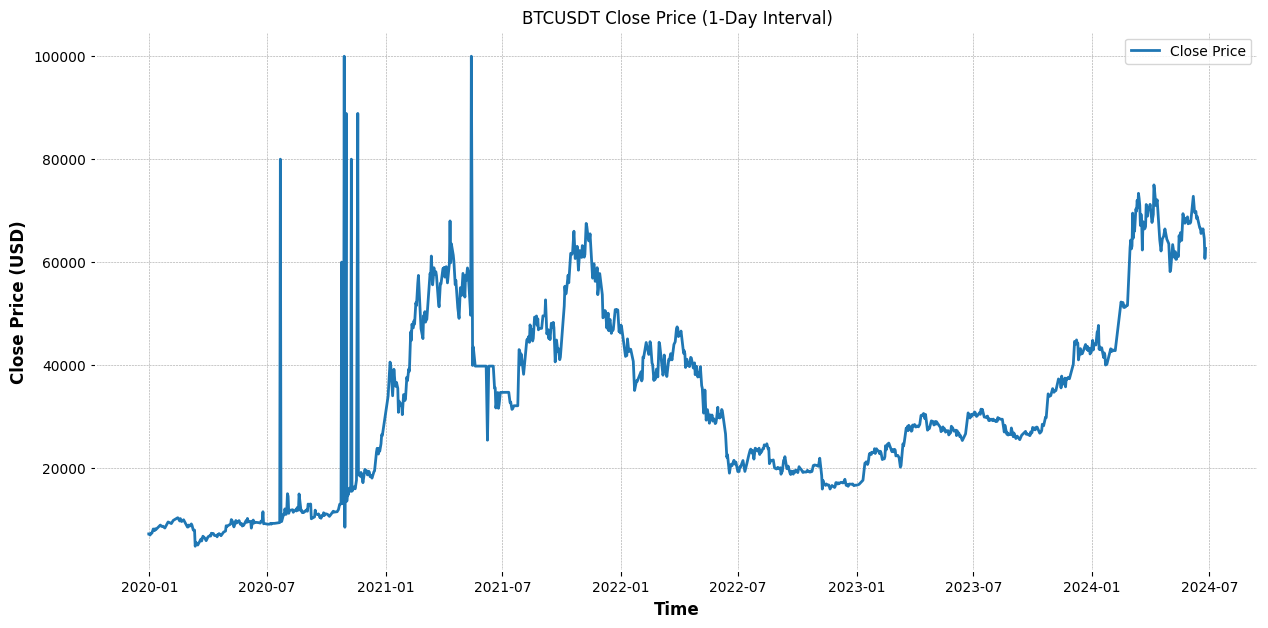

In [199]:
# Plot the 'Close' price over time
plt.figure(figsize = (15, 7))
plt.plot(BTCUSDT_Filtered_data_1D['Close'], label = 'Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Displaying The Candle Stick Graph For BTCUSDT (1 Month Interval): Using mpf Library

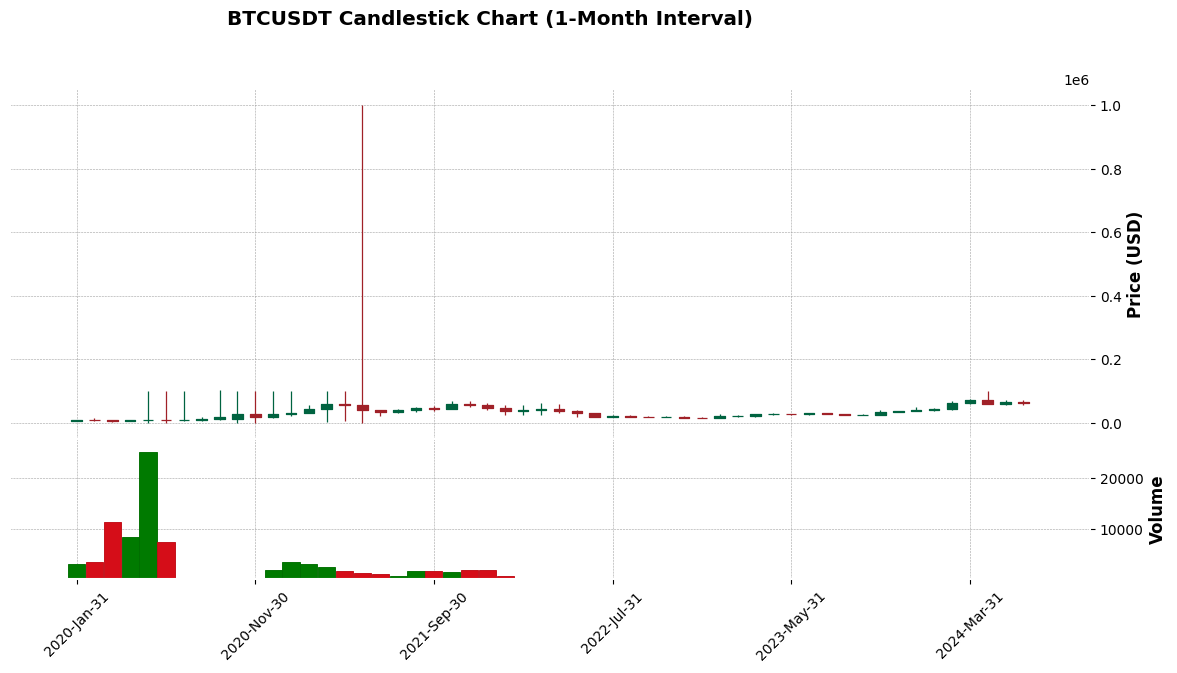

In [200]:
# Plot the candlestick chart
mpf.plot(
    BTCUSDT_Filtered_data_1Mnth,
    type         = 'candle',
    style        = 'charles',
    title        = 'BTCUSDT Candlestick Chart (1-Month Interval)',
    ylabel       = 'Price (USD)',
    volume       = True,
    ylabel_lower = 'Volume',
    figsize      = (15, 7)
)

### Displaying The Candle Stick Graph For BTCUSDT (1 Month Interval): Using matplotlib Library

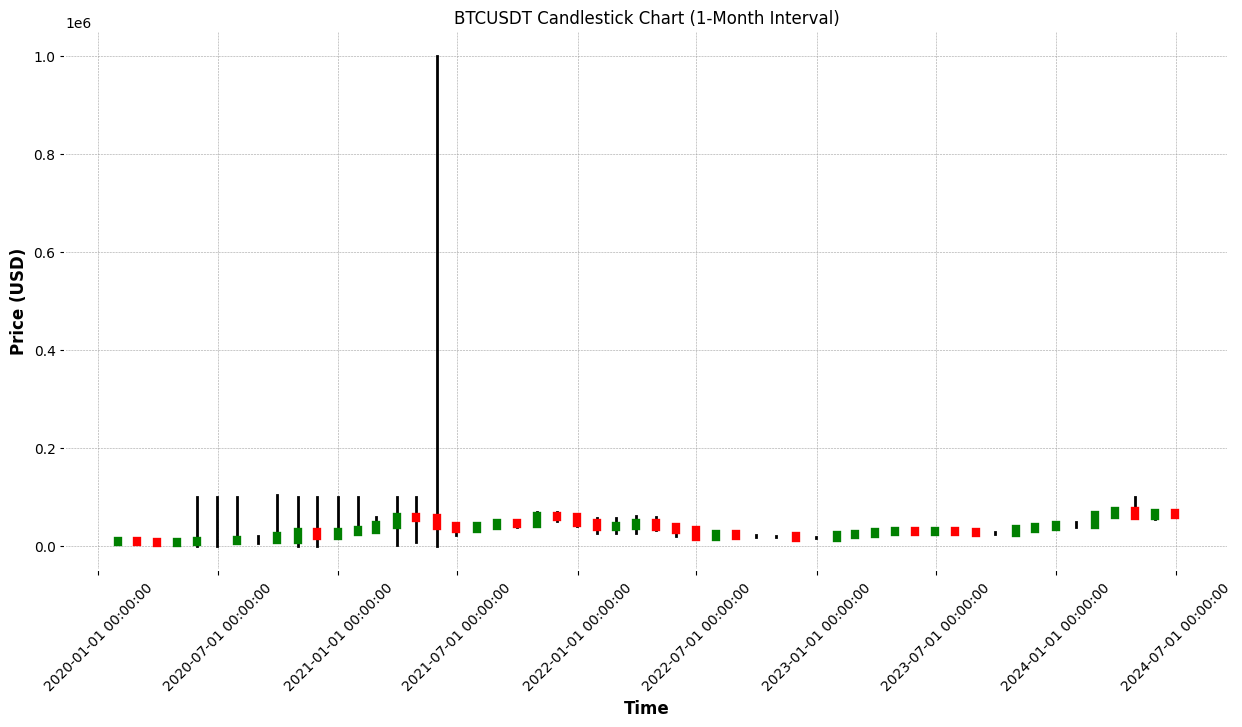

In [201]:
plot_candlestick_chart(copy.deepcopy(BTCUSDT_Filtered_data_1Mnth), interval = '1-Month')

## Now, Enough Plotting! On The Task!

### Calculating EMA On All Given Timespans

In [206]:
# Calculate EMA for the 4-Hour data
BTCUSDT_Filtered_data_4H_with_ema = calculate_ema(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 14, fillna = True)
BTCUSDT_Filtered_data_4H_with_ema

,Open,High,Low,Close,Volume,EMA_14
Open time (4H),,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,7174.140000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,7176.993333
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,7183.387556
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,7186.798548
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,7188.113408
...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,64420.997403
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,63698.597749
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,63298.558049


In [208]:
# Calculate EMA for the 8-Hour data
BTCUSDT_Filtered_data_8H_with_ema = calculate_ema(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 14, fillna = True)
BTCUSDT_Filtered_data_8H_with_ema

,Open,High,Low,Close,Volume,EMA_14
Open time (8H),,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,7197.330667
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,7202.001244
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,7201.874412
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,7189.837824
...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,65759.630127
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,65556.239444
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,65098.780851


In [209]:
# Calculate EMA for the 12-Hour data
BTCUSDT_Filtered_data_12H_with_ema = calculate_ema(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 14, fillna = True)
BTCUSDT_Filtered_data_12H_with_ema

,Open,High,Low,Close,Volume,EMA_14
Open time (12H),,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,7195.689333
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,7196.404089
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,7189.070210
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,7159.307516
...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,66177.226092
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,65964.649280
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,65371.442709


In [210]:
# Calculate EMA for the 4-Hour data
BTCUSDT_Filtered_data_1D_with_ema = calculate_ema(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 14, fillna = True)
BTCUSDT_Filtered_data_1D_with_ema

,Open,High,Low,Close,Volume,EMA_14
Open time (1D),,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,7196.274667
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,7165.551378
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,7188.733861
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,7210.520013
...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,67163.471230
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,66985.421732
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,66665.085501


### Calculating SMA On All Given Timespans

In [218]:
# Calculate SMA with a window of 14
BTCUSDT_Filtered_data_4H_with_sma = calculate_sma(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 14, fillna = True)
BTCUSDT_Filtered_data_4H_with_sma

,Open,High,Low,Close,Volume,SMA_14
Open time (4H),,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,7174.140000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,7184.840000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,7198.210000
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,7200.900000
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,7200.052000
...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,64890.807143
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,64409.050000
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,64031.435714


In [219]:
# Calculate SMA with a window of 14
BTCUSDT_Filtered_data_8H_with_sma = calculate_sma(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 14, fillna = True)
BTCUSDT_Filtered_data_8H_with_sma

,Open,High,Low,Close,Volume,SMA_14
Open time (8H),,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,7202.255000
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,7212.290000
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,7209.480000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,7189.904000
...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,65862.621429
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,65750.321429
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,65477.485714


In [220]:
# Calculate SMA with a window of 14
BTCUSDT_Filtered_data_12H_with_sma = calculate_sma(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 14, fillna = True)
BTCUSDT_Filtered_data_12H_with_sma

,Open,High,Low,Close,Volume,SMA_14
Open time (12H),,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,7196.100000
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,7197.750000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,7183.662500
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,7140.100000
...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,65992.178571
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,65845.485714
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,65482.314286


In [221]:
# Calculate SMA with a window of 14
BTCUSDT_Filtered_data_1D_with_sma = calculate_sma(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 14, fillna = True)
BTCUSDT_Filtered_data_1D_with_sma

,Open,High,Low,Close,Volume,SMA_14
Open time (1D),,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,7198.295000
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,7120.813333
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,7175.465000
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,7210.798000
...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,67582.800000
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,67309.371429
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,66946.735714


### Calculating SMMA On All Given Timespans

In [228]:
# Calculate SMMA with a window of 12
BTCUSDT_Filtered_data_4H_with_smma = calculate_smma(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 12)
BTCUSDT_Filtered_data_4H_with_smma

,Open,High,Low,Close,Volume,SMMA
Open time (4H),,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,0.000000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,0.000000
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,0.000000
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,0.000000
...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,64925.424168
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,64431.888821
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,64120.756419


In [230]:
# Calculate SMMA with a window of 12
BTCUSDT_Filtered_data_8H_with_smma = calculate_smma(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 12)
BTCUSDT_Filtered_data_8H_with_smma

,Open,High,Low,Close,Volume,SMMA
Open time (8H),,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,0.000000
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,0.000000
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,0.000000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,0.000000
...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,66110.278891
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,65953.938984
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,65634.885735


In [231]:
# Calculate SMMA with a window of 12
BTCUSDT_Filtered_data_12H_with_smma = calculate_smma(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 12)
BTCUSDT_Filtered_data_12H_with_smma

,Open,High,Low,Close,Volume,SMMA
Open time (12H),,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,0.000000
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,0.000000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,0.000000
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,0.000000
...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,66645.651467
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,66473.755511
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,66060.575885


In [232]:
# Calculate SMMA with a window of 12
BTCUSDT_Filtered_data_1D_with_smma = calculate_smma(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 12)
BTCUSDT_Filtered_data_1D_with_smma

,Open,High,Low,Close,Volume,SMMA
Open time (1D),,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,0.000000
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,0.000000
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,0.000000
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,0.000000
...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,67387.313752
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,67257.379272
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,67034.506000


### Calculating VWMA On All Given Timespans

In [233]:
# Calculate VWMA with a length of 14
BTCUSDT_Filtered_data_4H_with_vwma = calculate_vwma(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 14)
BTCUSDT_Filtered_data_4H_with_vwma

,Open,High,Low,Close,Volume,VWMA_Manual
Open time (4H),,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,7174.140000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,7185.324161
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,7224.041215
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,7223.852087
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,7223.543398
...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,63662.651244
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,62692.623305
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,62534.942670


In [234]:
# Calculate VWMA with a length of 14
BTCUSDT_Filtered_data_8H_with_vwma = calculate_vwma(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 14)
BTCUSDT_Filtered_data_8H_with_vwma

,Open,High,Low,Close,Volume,VWMA_Manual
Open time (8H),,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,7208.657794
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,7209.168667
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,7208.983289
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,7206.896796
...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,65975.315431
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,65837.184929
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,65251.619933


In [235]:
# Calculate VWMA with a length of 14
BTCUSDT_Filtered_data_12H_with_vwma = calculate_vwma(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 14)
BTCUSDT_Filtered_data_12H_with_vwma

,Open,High,Low,Close,Volume,VWMA_Manual
Open time (12H),,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,7196.621827
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,7196.766015
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,7195.033586
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,7188.321184
...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,65897.484911
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,65777.657665
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,65170.880558


In [236]:
# Calculate VWMA with a length of 14
BTCUSDT_Filtered_data_1D_with_vwma = calculate_vwma(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 14)
BTCUSDT_Filtered_data_1D_with_vwma

,Open,High,Low,Close,Volume,VWMA_Manual
Open time (1D),,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,7195.540000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,7200.698234
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,7187.108015
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,7195.910745
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,7203.476493
...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,67453.055110
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,67188.058761
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,66891.799293


### Calculating RSI On All Given Timespans

In [237]:
# Calculate rsi with a window of 14
BTCUSDT_Filtered_data_4H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 14, fillna = True)
BTCUSDT_Filtered_data_4H_with_rsi

,Open,High,Low,Close,Volume,RSI
Open time (4H),,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,100.000000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,100.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,100.000000
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,74.117822
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,61.016526
...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,27.520275
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,18.656209
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,31.548243


In [238]:
# Calculate rsi with a window of 14
BTCUSDT_Filtered_data_8H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 14, fillna = True)
BTCUSDT_Filtered_data_8H_with_rsi

,Open,High,Low,Close,Volume,RSI
Open time (8H),,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,100.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,100.000000
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,100.000000
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,51.539435
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,20.690465
...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,37.318297
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,35.451905
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,26.741240


In [239]:
# Calculate rsi with a window of 14
BTCUSDT_Filtered_data_12H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 14, fillna = True)
BTCUSDT_Filtered_data_12H_with_rsi

,Open,High,Low,Close,Volume,RSI
Open time (12H),,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,100.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,100.000000
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,100.000000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,7.794058
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,1.987083
...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,41.916526
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,36.760718
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,26.376225


In [240]:
# Calculate rsi with a window of 14
BTCUSDT_Filtered_data_1D_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 14, fillna = True)
BTCUSDT_Filtered_data_1D_with_rsi

,Open,High,Low,Close,Volume,RSI
Open time (1D),,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,100.000000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,100.000000
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,2.129038
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,63.399979
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,64.220691
...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,45.000002
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,42.049137
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,36.920268


### Calculating Stochastic RSI On All Given Timespans

In [241]:
# Calculate StochRSI
BTCUSDT_Filtered_data_4H_with_stochrsi = calculate_stochrsi(
    copy.deepcopy(BTCUSDT_Filtered_data_4H),
    window = 14,
    smooth1 = 3,
    smooth2 = 3,
    fillna = True
)

BTCUSDT_Filtered_data_4H_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D
Open time (4H),,,,,,,,
2019-12-31 16:00:00,7169.71,7183.07,7156.65,7174.14,3200.843000,0.000000,0.000000,0.000000
2019-12-31 20:00:00,7173.42,7209.48,7164.51,7195.54,3504.239258,0.000000,0.000000,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7224.95,285657.260546,0.000000,0.000000,0.000000
2020-01-01 04:00:00,7224.95,7235.71,7198.70,7208.97,3715.465633,0.000000,0.000000,0.000000
2020-01-01 08:00:00,7208.97,7236.58,7178.00,7196.66,3399.718654,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-06-24 12:00:00,61515.60,63998.80,60000.00,62125.30,9.058333,0.237807,7.926907,4.457034
2024-06-24 16:00:00,62125.30,62934.50,59000.10,59003.00,26.726867,0.000000,7.926907,6.191971
2024-06-24 20:00:00,59318.10,61333.20,59003.10,60698.30,8.833612,0.419690,21.916584,12.590133


In [242]:
# Calculate StochRSI
BTCUSDT_Filtered_data_8H_with_stochrsi = calculate_stochrsi(
    copy.deepcopy(BTCUSDT_Filtered_data_8H),
    window = 14,
    smooth1 = 3,
    smooth2 = 3,
    fillna = True
)

BTCUSDT_Filtered_data_8H_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D
Open time (8H),,,,,,,,
2019-12-31 16:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000,0.000000,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7208.97,144686.363090,0.000000,0.000000,0.000000
2020-01-01 08:00:00,7208.97,7253.21,7178.00,7232.36,3263.093594,0.000000,0.000000,0.000000
2020-01-01 16:00:00,7232.36,7248.09,7177.13,7201.05,3537.603192,0.000000,0.000000,0.000000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7111.60,3392.156488,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-06-23 16:00:00,65020.00,65829.20,64500.10,64582.90,10.469583,0.000000,22.466217,37.113602
2024-06-24 00:00:00,64583.00,65290.60,63800.00,64234.20,11.982344,0.000000,6.221792,22.428727
2024-06-24 08:00:00,64231.60,64567.00,58301.80,62125.30,25.285871,0.000000,0.000000,9.562670


In [243]:
# Calculate StochRSI
BTCUSDT_Filtered_data_12H_with_stochrsi = calculate_stochrsi(
    copy.deepcopy(BTCUSDT_Filtered_data_12H),
    window = 14,
    smooth1 = 3,
    smooth2 = 3,
    fillna = True
)

BTCUSDT_Filtered_data_12H_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D
Open time (12H),,,,,,,,
2019-12-31 12:00:00,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000,0.000000,0.000000
2020-01-01 00:00:00,7195.54,9592.00,6871.45,7196.66,97590.814944,0.000000,0.000000,0.000000
2020-01-01 12:00:00,7196.66,7253.21,7177.13,7201.05,3400.558306,0.000000,0.000000,0.000000
2020-01-02 00:00:00,7201.05,7212.59,7105.17,7141.40,3373.372638,0.000000,0.000000,0.000000
2020-01-02 12:00:00,7141.16,7163.16,6934.53,6965.85,3252.792972,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-06-23 00:00:00,65828.10,65899.80,65400.00,65614.90,3.039614,0.661738,70.761371,71.491182
2024-06-23 12:00:00,65615.00,65880.20,64500.10,64582.90,9.902778,0.258719,55.759560,69.519239
2024-06-24 00:00:00,64583.00,65290.60,58301.80,61515.60,21.826032,0.000000,30.681876,52.400936


In [244]:
# Calculate StochRSI
BTCUSDT_Filtered_data_1D_with_stochrsi = calculate_stochrsi(
    copy.deepcopy(BTCUSDT_Filtered_data_1D),
    window = 14,
    smooth1 = 3,
    smooth2 = 3,
    fillna = True
)

BTCUSDT_Filtered_data_1D_with_stochrsi

,Open,High,Low,Close,Volume,StochRSI,StochRSI_K,StochRSI_D
Open time (1D),,,,,,,,
2019-12-31,7169.71,7209.48,7156.65,7195.54,3443.560007,0.000000,0.000000,0.000000
2020-01-01,7195.54,9592.00,6871.45,7201.05,50495.686625,0.000000,0.000000,0.000000
2020-01-02,7201.05,7212.59,6934.53,6965.85,3313.082805,0.000000,0.000000,0.000000
2020-01-03,6965.88,7600.00,6871.45,7339.42,3511.806903,0.000000,0.000000,0.000000
2020-01-04,7340.57,7400.00,7260.00,7352.13,3092.602082,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-06-21,65830.10,71341.20,64100.00,66461.10,15.895574,0.308569,15.746420,7.851470
2024-06-22,66382.90,66461.10,64983.20,65828.10,4.936312,0.145326,18.243400,13.150202
2024-06-23,65828.10,65899.80,64500.10,64582.90,6.471196,0.000000,15.129818,16.373213


### The Python Script Is Written In VS Code

# ***More Later!***